In [ ]:
# Standard library imports
import os
import random
import json
from collections import Counter

# Third-party library imports
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class CarPartsDataset(Dataset):
    def __init__(self, base_image_dir, txt_dir, label_mapping_file, transform=None, num_samples_per_model=10):
        self.base_image_dir = base_image_dir
        self.txt_dir = txt_dir
        self.transform = transform
        self.num_samples_per_model = num_samples_per_model

        # Load the label mapping from JSON file.
        with open(label_mapping_file, 'r') as f:
            self.label_to_idx = json.load(f)

        # List to store datapoints as tuples: (list of 8 image paths, label)
        self.data = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        # Dictionary to group images by car model.
        # Format: grouped_data[car_model][part] = list of full image paths.
        grouped_data = {}

        # For each car part (1 to 8), read its text file.
        for part in range(1, 9):
            txt_file = os.path.join(self.txt_dir, f"test_part_{part}.txt")
            if not os.path.exists(txt_file):
                print(f"Warning: {txt_file} not found.")
                continue

            with open(txt_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    # Expected line format: car_make/car_model/year/part/filename.jpg
                    # Example: "78/1/2014/1/fa6d0ee4f0bcde.jpg"
                    parts = line.split('/')
                    if len(parts) < 5:
                        continue  # Skip invalid lines.
                    car_make = parts[0]
                    car_model = parts[1]
                    # Build the full path by joining the base directory and the relative path.
                    full_path = os.path.join(self.base_image_dir, line)
                    
                    # Initialize the car_model entry if not present.
                    if car_model not in grouped_data:
                        # Create an entry for parts 1 to 8.
                        grouped_data[car_model] = {str(i): [] for i in range(1, 9)}
                    
                    # Append the image to the corresponding part.
                    grouped_data[car_model][str(part)].append(full_path)

        # Create samples per car model.
        for car_model, parts_images in grouped_data.items():
            # Ensure that every part has at least one image.
            if not all(len(img_list) > 0 for img_list in parts_images.values()):
                continue

            # Map the car model to its label using the provided JSON mapping.
            if car_model not in self.label_to_idx:
                continue  # Skip if not found in the mapping.
            label = self.label_to_idx[car_model]

            # Create the specified number of samples for this car model.
            for _ in range(self.num_samples_per_model):
                sample_paths = []
                # Ensure a consistent order (parts 1 to 8).
                for part in sorted(parts_images.keys(), key=lambda x: int(x)):
                    chosen_img = random.choice(parts_images[part])
                    sample_paths.append(chosen_img)
                self.data.append((sample_paths, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_paths, label = self.data[idx]
        images = []
        for path in image_paths:
            # Open the image and convert to RGB.
            img = Image.open(path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            images.append(img)
        return images, label


## ResNet 50

In [3]:
# Define any image transformations  - resnet 50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    # Add normalization or other transforms if needed.
])

# Path to the data directory and the label mapping JSON file.
data_root = "/data/NNDL/data/part"
label_mapping_file = "label_to_idx.json"

# Create the dataset.
dataset = CarPartsDataset( base_image_dir= '/data/NNDL/data/part', txt_dir= '/data/NNDL/data/train_test_split/part',
                            label_mapping_file=label_mapping_file,
                            transform=transform,
                            num_samples_per_model=10)

#Get the first datapoint.
images, label = dataset[0]
print(f"Label: {label}")
print(f"Number of images: {len(images)}")


Label: 0
Number of images: 8


In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize(img, mean, std):
    # Convert mean and std to tensors and reshape for broadcasting.
    mean_tensor = torch.tensor(mean, dtype=img.dtype, device=img.device)[:, None, None]
    std_tensor = torch.tensor(std, dtype=img.dtype, device=img.device)[:, None, None]
    return img * std_tensor + mean_tensor

def plot_random_samples(dataset, num_samples=4):
    # Randomly choose indices from the dataset.
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create a figure with `num_samples` rows and 8 columns.
    fig, axes = plt.subplots(num_samples, 8, figsize=(20, 5*num_samples))
    
    # If there's only one sample, axes will be a 1D array, so wrap it in a list.
    if num_samples == 1:
        axes = [axes]
    
    for row_idx, sample_idx in enumerate(indices):
        images, label = dataset[sample_idx]
        
        # Iterate over the 8 car parts.
        for col_idx, img in enumerate(images):
            # Access the proper axis.
            ax = axes[row_idx][col_idx] if num_samples > 1 else axes[col_idx]
            
            # If the image is a tensor, unnormalize and convert it to a NumPy array.
            if isinstance(img, torch.Tensor):
                # Unnormalize the image for better visualization
                img = unnormalize(img, mean, std)
                # Convert from (C, H, W) to (H, W, C)
                img_np = img.permute(1, 2, 0).numpy()
                # Clip values in case they're not in [0, 1]
                img_np = img_np.clip(0, 1)
            else:
                img_np = img
                
            ax.imshow(img_np)
            ax.axis('off')
            ax.set_title(f"Part {col_idx+1}")
        
        # Add the car model label as a ylabel for the first column of each row.
        axes[row_idx][0].set_ylabel(f"Label: {label}", fontsize=14, rotation=0, labelpad=50)
    
    plt.tight_layout()
    plt.show()


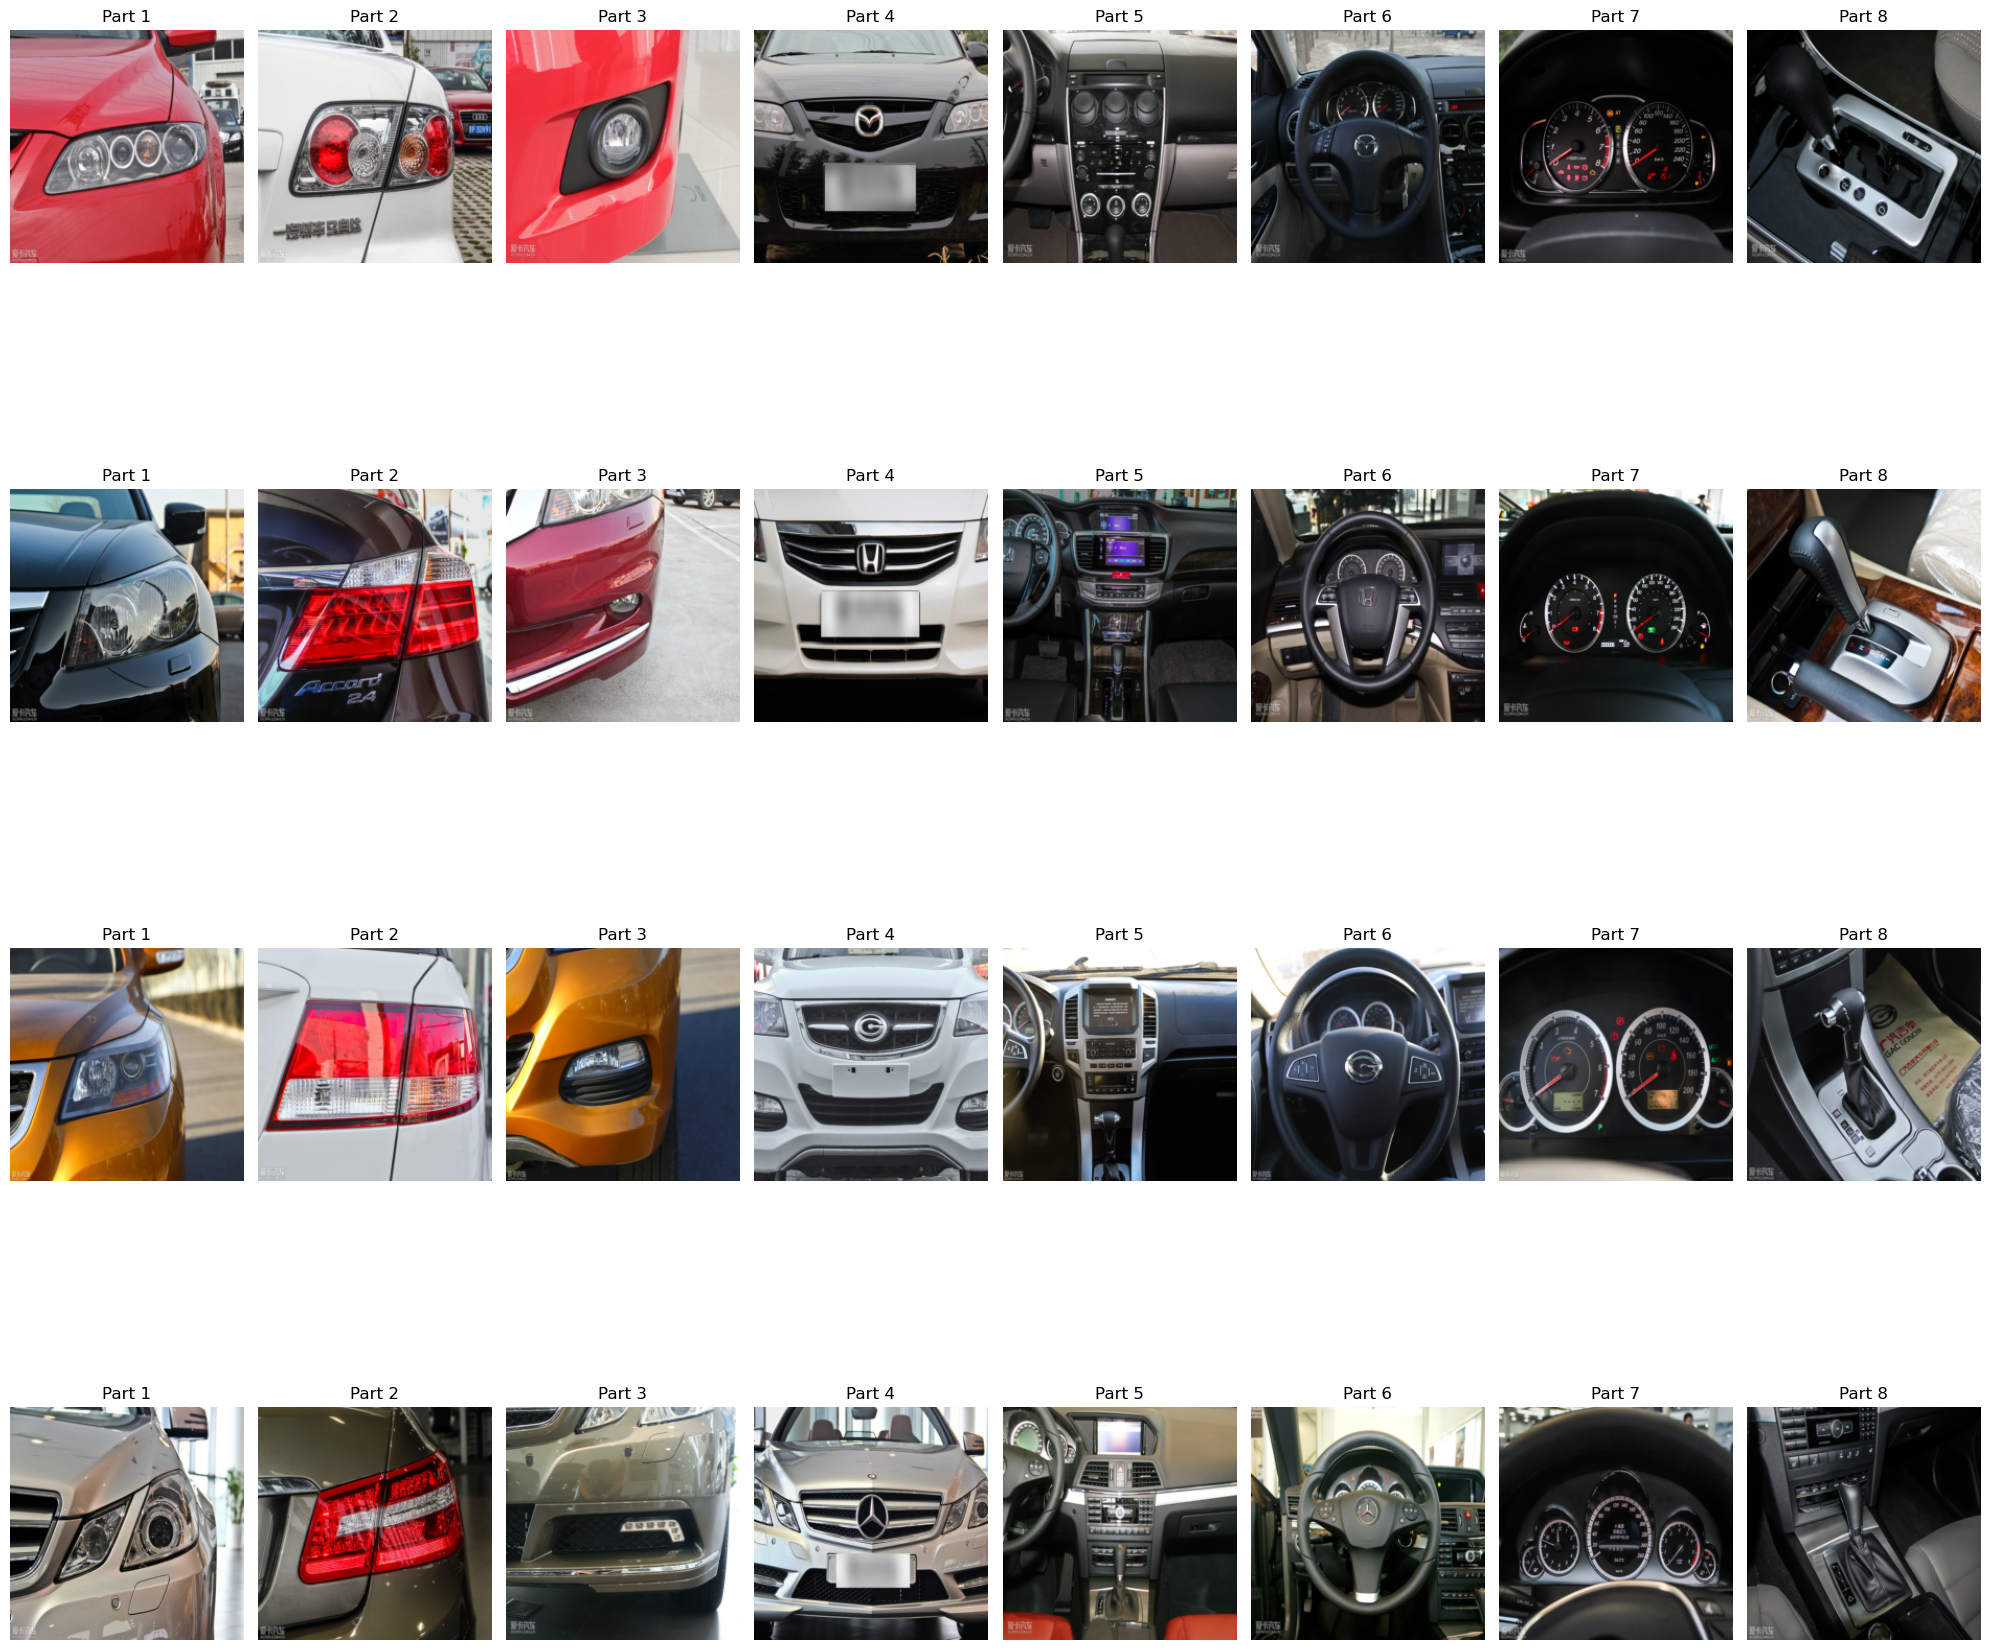

In [17]:
plot_random_samples(dataset, num_samples=4)

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define a custom collate function
def custom_collate(batch):
    images_list, labels = zip(*batch)  
    batch_images = [torch.stack(imgs, dim=0) for imgs in zip(*images_list)]
    batch_labels = torch.tensor(labels)
    return batch_images, batch_labels

# 2. Create a DataLoader
dataloader = DataLoader(
    dataset, 
    batch_size=32,        
    shuffle=False, 
    num_workers=16, 
    pin_memory=True, 
    prefetch_factor=2, 
    persistent_workers=True,        
    collate_fn=custom_collate
)

# 3. Load the models for each car part
num_parts = 8
num_classes = len(dataset.label_to_idx)
models_dict = {}

for part_idx in range(1, num_parts+1):
    # Create a ResNet50 model.
    model = models.resnet50(pretrained=False)
    # Replace the final fully connected layer to match the number of classes.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Construct the file name and load the model.
    model_path = f"part_{part_idx}_predictor_resnet50_model.pth"
    state_dict = torch.load(model_path, map_location=device)
    # If the state dict keys are different.
    if "fc.1.weight" in state_dict and "fc.1.bias" in state_dict:
        state_dict["fc.weight"] = state_dict.pop("fc.1.weight")
        state_dict["fc.bias"] = state_dict.pop("fc.1.bias")
    model.load_state_dict(state_dict)
    
    model.to(device)
    model.eval()
    models_dict[part_idx] = model
    print(f"Loaded model for part {part_idx} from {model_path}")

# 4. Evaluate on the dataset using the DataLoader

# Initialize counters for top-1 and top-5 accuracies per part.
part_correct_top1 = {i: 0 for i in range(1, num_parts+1)}
part_correct_top5 = {i: 0 for i in range(1, num_parts+1)}
voting_correct = 0         # Voting using top-1 predictions
voting_top5_correct = 0    # Voting using combined top-5 predictions from each part
total_samples = 0

# Iterate over the DataLoader with a progress bar.
for batch_images, batch_labels in tqdm(dataloader, desc="Evaluating batches"):
    batch_size = batch_labels.size(0)
    total_samples += batch_size
    
    # Dictionaries to store predictions for this batch.
    batch_predictions_top1 = {}  # For each part, store top-1 predictions.
    batch_predictions_top5 = {}  # For each part, store top-5 predictions.
    
    # Process each part.
    for part_idx in range(1, num_parts+1):
        imgs = batch_images[part_idx-1].to(device)  # shape: (batch_size, C, H, W)
        
        with torch.no_grad():
            outputs = models_dict[part_idx](imgs)  # shape: (batch_size, num_classes)
            preds_top1 = outputs.argmax(dim=1)     # top-1 prediction: (batch_size,)
            top5_preds = torch.topk(outputs, k=5, dim=1).indices  # top-5 indices: (batch_size, 5)
            
            # Store predictions (moved to CPU for further processing).
            batch_predictions_top1[part_idx] = preds_top1.cpu()
            batch_predictions_top5[part_idx] = top5_preds.cpu()
        
        # Update individual part accuracies.
        part_correct_top1[part_idx] += (preds_top1.cpu() == batch_labels).sum().item()
        part_correct_top5[part_idx] += (top5_preds.cpu() == batch_labels.unsqueeze(1)).any(dim=1).sum().item()
    
    # For each sample in the batch, perform ensemble voting.
    for i in range(batch_size):
        true_label = batch_labels[i].item()
        
        # Voting based on top-1 predictions.
        sample_top1 = [batch_predictions_top1[part_idx][i].item() for part_idx in range(1, num_parts+1)]
        vote_counter = Counter(sample_top1)
        voted_pred, _ = vote_counter.most_common(1)[0]
        if voted_pred == true_label:
            voting_correct += 1
        
        # Voting based on combined top-5 predictions.
        # Each part gives 5 predictions; combine all 5*8 predictions.
        sample_top5 = []
        for part_idx in range(1, num_parts+1):
            sample_top5.extend(batch_predictions_top5[part_idx][i].tolist())
        vote_counter_top5 = Counter(sample_top5)
        # Select the 5 most common labels from the combined predictions.
        voted_top5 = [label for label, count in vote_counter_top5.most_common(5)]
        if true_label in voted_top5:
            voting_top5_correct += 1

# Calculate per-part accuracies.
part_top1_accuracies = {i: part_correct_top1[i] / total_samples for i in range(1, num_parts+1)}
part_top5_accuracies = {i: part_correct_top5[i] / total_samples for i in range(1, num_parts+1)}

# Calculate ensemble voting accuracies.
voting_accuracy = voting_correct / total_samples
voting_top5_accuracy = voting_top5_correct / total_samples

print("\nPer car part model accuracies (Top-1):")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_top1_accuracies[part_idx]*100:.2f}%")

print("\nPer car part model accuracies (Top-5):")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_top5_accuracies[part_idx]*100:.2f}%")

print(f"\nVoting Accuracy (Top-1 majority vote): {voting_accuracy*100:.2f}%")
print(f"Voting Accuracy (Top-5 majority vote): {voting_top5_accuracy*100:.2f}%")


/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1771743/1161055318.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limi

Loaded model for part 1 from part_1_predictor_resnet50_model.pth
Loaded model for part 2 from part_2_predictor_resnet50_model.pth
Loaded model for part 3 from part_3_predictor_resnet50_model.pth
Loaded model for part 4 from part_4_predictor_resnet50_model.pth
Loaded model for part 5 from part_5_predictor_resnet50_model.pth
Loaded model for part 6 from part_6_predictor_resnet50_model.pth
Loaded model for part 7 from part_7_predictor_resnet50_model.pth
Loaded model for part 8 from part_8_predictor_resnet50_model.pth


Evaluating batches: 100%|██████████| 135/135 [00:41<00:00,  3.27it/s]


Per car part model accuracies (Top-1):
Part 1: 53.28%
Part 2: 64.00%
Part 3: 29.19%
Part 4: 50.67%
Part 5: 54.42%
Part 6: 54.72%
Part 7: 52.86%
Part 8: 38.81%

Per car part model accuracies (Top-5):
Part 1: 71.53%
Part 2: 82.37%
Part 3: 48.42%
Part 4: 73.40%
Part 5: 75.88%
Part 6: 78.42%
Part 7: 76.65%
Part 8: 60.95%

Voting Accuracy (Top-1 majority vote): 81.51%
Voting Accuracy (Top-5 majority vote): 96.74%


## Inception v3

In [12]:
# Define any image transformations - inception v3
transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_root = "/data/NNDL/data/part"
label_mapping_file = "label_to_idx.json"


dataset = CarPartsDataset( base_image_dir= '/data/NNDL/data/part', txt_dir= '/data/NNDL/data/train_test_split/part',
                            label_mapping_file=label_mapping_file,
                            transform=transform,
                            num_samples_per_model=10)


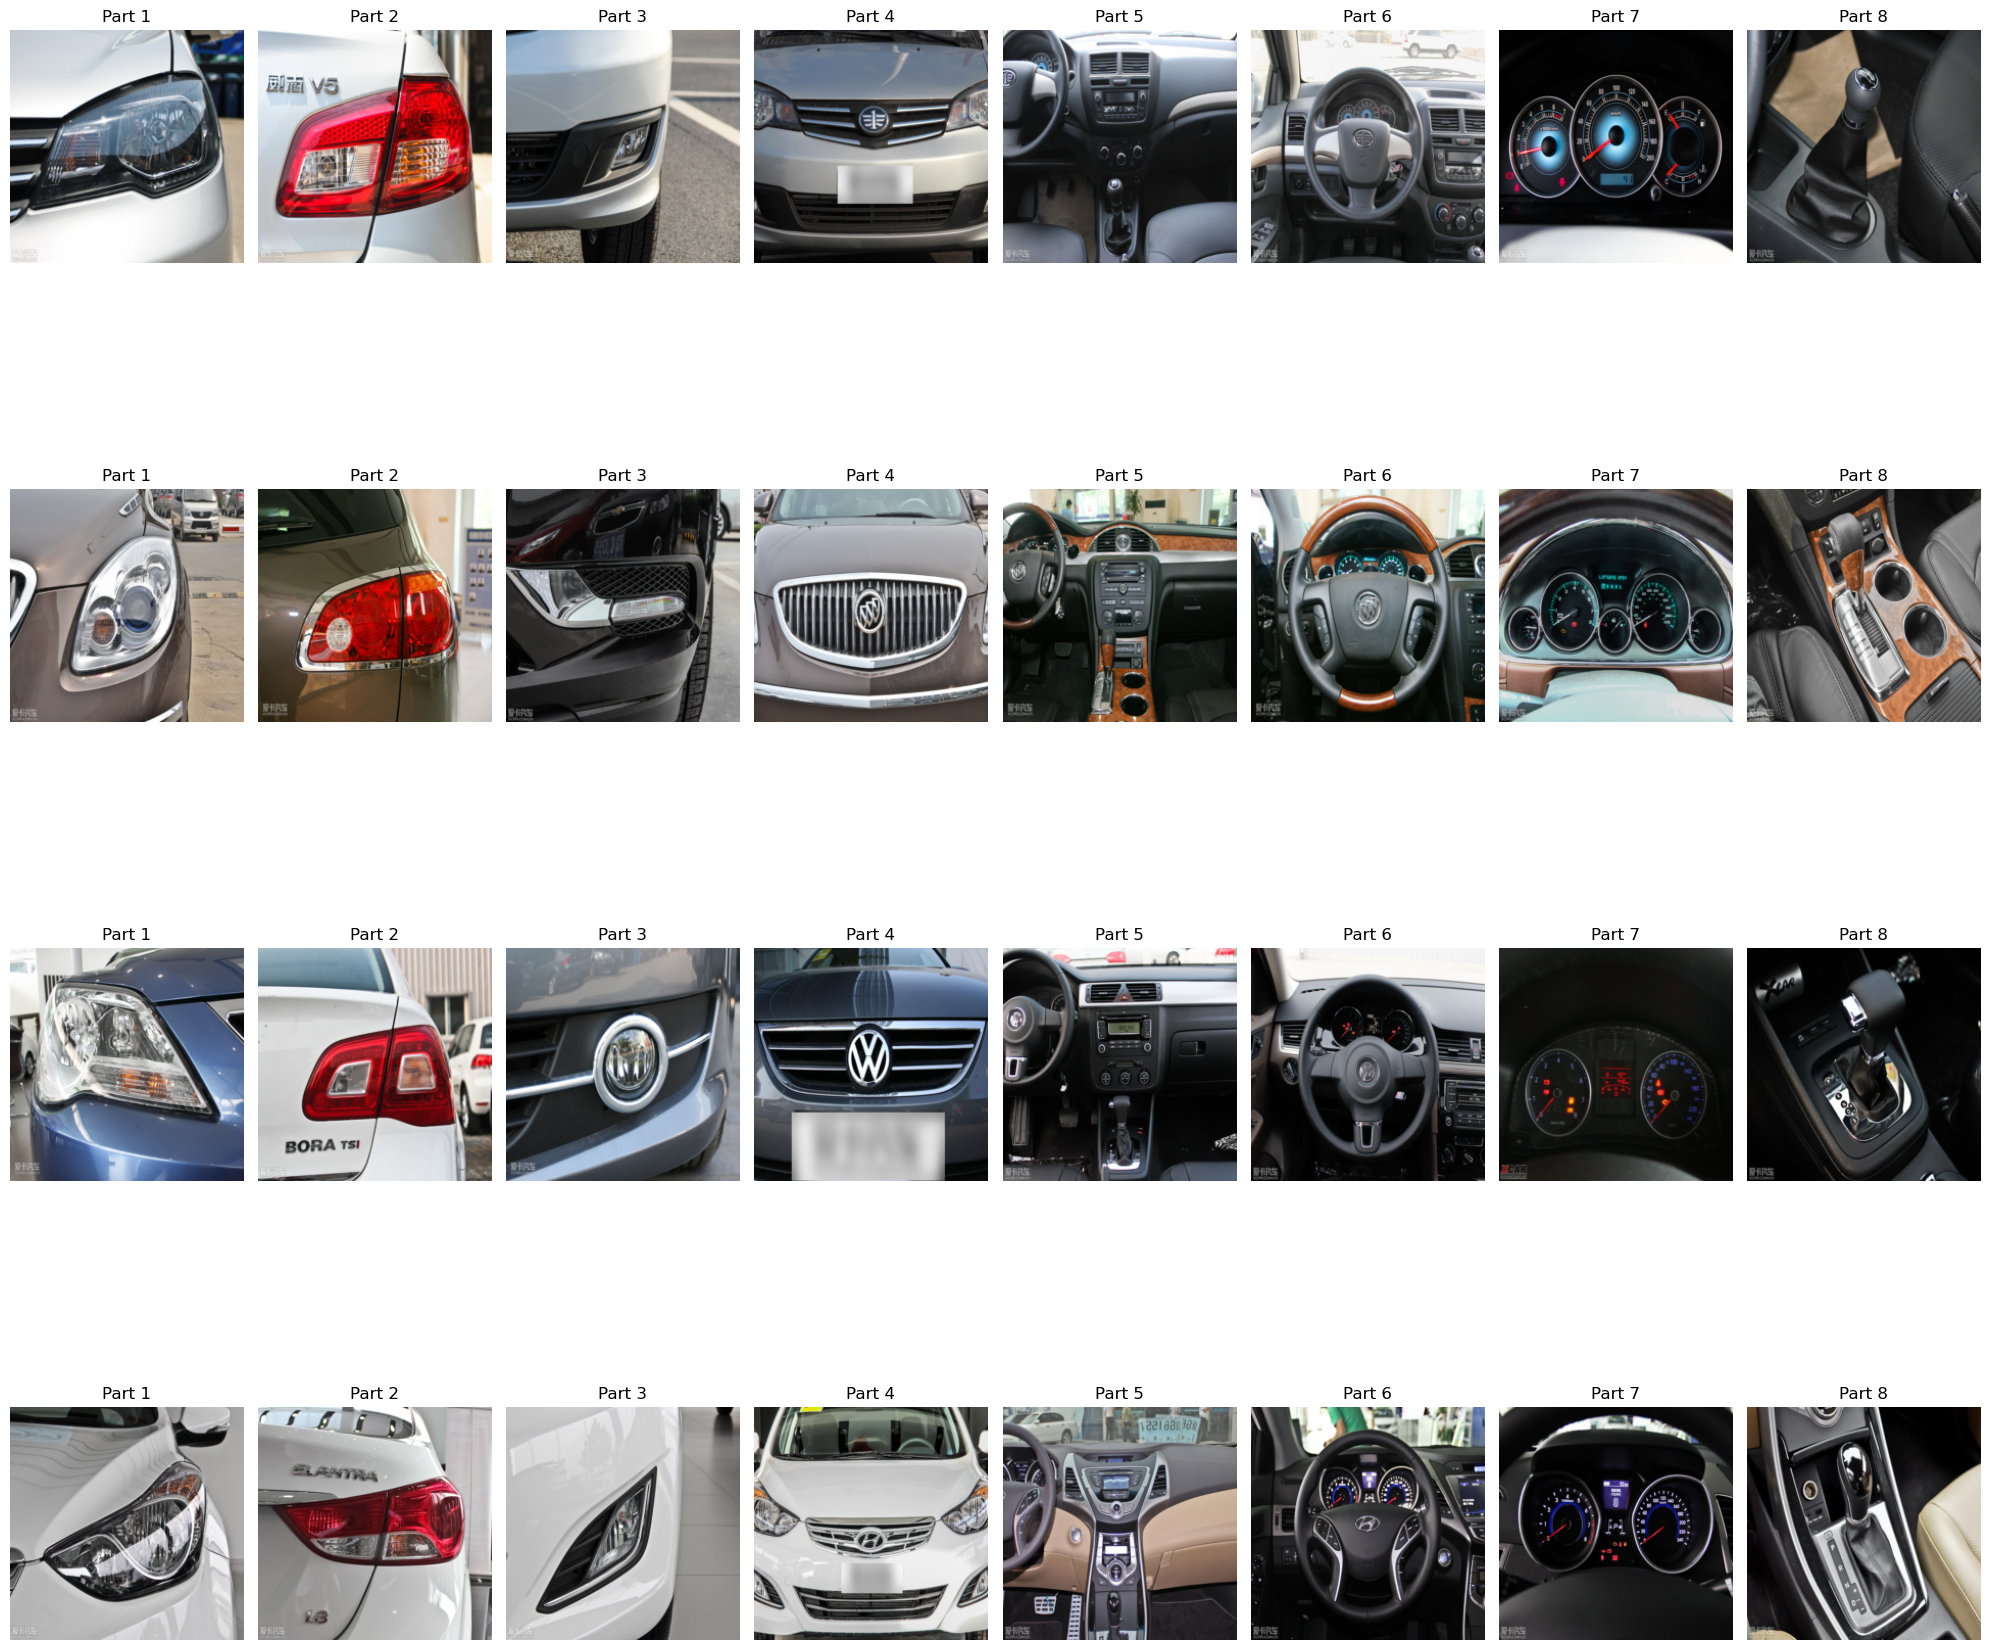

In [15]:
plot_random_samples(dataset, num_samples=4)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    dataset, 
    batch_size=32,       
    shuffle=False, 
    num_workers=16, 
    pin_memory=True, 
    prefetch_factor=2, 
    persistent_workers=True,       
    collate_fn=custom_collate
)

num_parts = 8
num_classes = len(dataset.label_to_idx)
models_dict = {}

for part_idx in range(1, num_parts+1):
    # Create an Inception v3 model.
    model = models.inception_v3(pretrained=False, aux_logits=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    if model.AuxLogits is not None:
        num_ftrs_aux = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
    model_path = f"part_{part_idx}_predictor_inception_model.pth"
    state_dict = torch.load(model_path, map_location=device)


    if "fc.1.weight" in state_dict and "fc.1.bias" in state_dict:
        state_dict["fc.weight"] = state_dict.pop("fc.1.weight")
        state_dict["fc.bias"] = state_dict.pop("fc.1.bias")
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    models_dict[part_idx] = model
    print(f"Loaded model for part {part_idx} from {model_path}")

part_correct_top1 = {i: 0 for i in range(1, num_parts+1)}
part_correct_top5 = {i: 0 for i in range(1, num_parts+1)}
voting_correct = 0
voting_top5_correct = 0
total_samples = 0

for batch_images, batch_labels in tqdm(dataloader, desc="Evaluating batches"):

    batch_size = batch_labels.size(0)
    total_samples += batch_size
    batch_predictions_top1 = {}
    batch_predictions_top5 = {}


    for part_idx in range(1, num_parts+1):
        imgs = batch_images[part_idx-1].to(device)


        with torch.no_grad():
            # In eval mode, Inception v3 returns only the main output.
            outputs = models_dict[part_idx](imgs)
            preds_top1 = outputs.argmax(dim=1)
            top5_preds = torch.topk(outputs, k=5, dim=1).indices
            batch_predictions_top1[part_idx] = preds_top1.cpu()
            batch_predictions_top5[part_idx] = top5_preds.cpu()
        part_correct_top1[part_idx] += (preds_top1.cpu() == batch_labels).sum().item()
        part_correct_top5[part_idx] += (top5_preds.cpu() == batch_labels.unsqueeze(1)).any(dim=1).sum().item()


    for i in range(batch_size):
        true_label = batch_labels[i].item()
        sample_top1 = [batch_predictions_top1[part_idx][i].item() for part_idx in range(1, num_parts+1)]
        voted_pred = Counter(sample_top1).most_common(1)[0][0]


        if voted_pred == true_label:
            voting_correct += 1
        sample_top5 = []

        for part_idx in range(1, num_parts+1):
            sample_top5.extend(batch_predictions_top5[part_idx][i].tolist())
        voted_top5 = [label for label, count in Counter(sample_top5).most_common(5)]

        if true_label in voted_top5:
            voting_top5_correct += 1

part_top1_accuracies = {i: part_correct_top1[i] / total_samples for i in range(1, num_parts+1)}
part_top5_accuracies = {i: part_correct_top5[i] / total_samples for i in range(1, num_parts+1)}
voting_accuracy = voting_correct / total_samples
voting_top5_accuracy = voting_top5_correct / total_samples

print("\nPer car part model accuracies (Top-1):")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_top1_accuracies[part_idx]*100:.2f}%")
print("\nPer car part model accuracies (Top-5):")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_top5_accuracies[part_idx]*100:.2f}%")
print(f"\nVoting Accuracy (Top-1 majority vote): {voting_accuracy*100:.2f}%")
print(f"Voting Accuracy (Top-5 majority vote): {voting_top5_accuracy*100:.2f}%")


/data/anaconda3/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/tmp/ipykernel_1771743/162195176.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Loaded model for part 1 from part_1_predictor_inception_model.pth
Loaded model for part 2 from part_2_predictor_inception_model.pth
Loaded model for part 3 from part_3_predictor_inception_model.pth
Loaded model for part 4 from part_4_predictor_inception_model.pth
Loaded model for part 5 from part_5_predictor_inception_model.pth
Loaded model for part 6 from part_6_predictor_inception_model.pth
Loaded model for part 7 from part_7_predictor_inception_model.pth
Loaded model for part 8 from part_8_predictor_inception_model.pth


Evaluating batches: 100%|██████████| 135/135 [00:43<00:00,  3.08it/s]


Per car part model accuracies (Top-1):
Part 1: 43.33%
Part 2: 57.00%
Part 3: 22.28%
Part 4: 26.19%
Part 5: 38.72%
Part 6: 37.30%
Part 7: 27.95%
Part 8: 11.93%

Per car part model accuracies (Top-5):
Part 1: 67.86%
Part 2: 78.47%
Part 3: 41.60%
Part 4: 48.49%
Part 5: 65.93%
Part 6: 65.86%
Part 7: 50.12%
Part 8: 24.14%

Voting Accuracy (Top-1 majority vote): 72.53%
Voting Accuracy (Top-5 majority vote): 96.77%
